### Zillow Property Value Prediction — Phase 2: Feature Engineering


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os
import matplotlib.pyplot as plt

### **1. Load Clean Dataset**

In [9]:
df = pd.read_csv("../data/processed/zillow_cleaned.csv")

print("Shape:", df.shape)
print(df.info())
print(df.describe().T)

Shape: (76723, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76723 entries, 0 to 76722
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         76723 non-null  float64
 1   bathroomcnt                   76723 non-null  float64
 2   bedroomcnt                    76723 non-null  float64
 3   buildingqualitytypeid         76723 non-null  float64
 4   calculatedfinishedsquarefeet  76723 non-null  float64
 5   fips                          76723 non-null  float64
 6   fireplacecnt                  76723 non-null  float64
 7   garagecarcnt                  76723 non-null  float64
 8   garagetotalsqft               76723 non-null  float64
 9   heatingorsystemtypeid         76723 non-null  float64
 10  latitude                      76723 non-null  float64
 11  longitude                     76723 non-null  float64
 12  lotsizesquarefeet             76723 non-n

### **2. Domain-Driven Features**

##### Prices per Square Foot, Age of Home, Bath per Bed

In [10]:
df['price_per_sqft'] = df['taxvaluedollarcnt'] / df['calculatedfinishedsquarefeet']
df["age_of_home"] = 2025 - df["yearbuilt"]
df["bath_per_bed"] = df["bathroomcnt"] / df["bedroomcnt"]


##### Rooms per Square Foot


In [11]:
df["rooms_per_sqft"] = df["roomcnt"] / (df["calculatedfinishedsquarefeet"] + 1e-5)

# Count how many rows have rooms_per_sqft = 0
zero_count = (df["rooms_per_sqft"] == 0).sum()
total_rows = len(df)
print(f"Rows with rooms_per_sqft = 0: {zero_count}")

# Check unique values and their counts
print(df["roomcnt"].value_counts().sort_index())
print(df["bathroomcnt"].value_counts().sort_index())
print(df["bedroomcnt"].value_counts().sort_index())


Rows with rooms_per_sqft = 0: 59131
roomcnt
0.0     59131
1.0         1
2.0         9
3.0       212
4.0      1422
5.0      3022
6.0      4519
7.0      3842
8.0      2872
9.0      1194
10.0      340
11.0      108
12.0       34
13.0       10
14.0        6
15.0        1
Name: count, dtype: int64
bathroomcnt
1.0     12739
1.5      1419
2.0     31537
2.5      6606
3.0     17346
3.5      1036
4.0      3353
4.5       696
5.0      1025
5.5       224
6.0       419
6.5        47
7.0       114
7.5        16
8.0       108
8.5         3
9.0        23
10.0        7
11.0        3
13.0        1
18.0        1
Name: count, dtype: int64
bedroomcnt
1.0      3387
2.0     19221
3.0     30428
4.0     17546
5.0      4550
6.0      1000
7.0       208
8.0       253
9.0        70
10.0       31
11.0        9
12.0       16
13.0        2
14.0        1
16.0        1
Name: count, dtype: int64


In [12]:
df["roomcnt_fixed"] = np.where(
    df["roomcnt"] > 0,
    df["roomcnt"], 
    df["bedroomcnt"] + df["bathroomcnt"] + 1)

df["rooms_per_sqft"] = df["roomcnt_fixed"] / (df["calculatedfinishedsquarefeet"] + 1e-5)

df = df.drop(columns=["roomcnt"])

Room Count vs Bedrooms/Bathrooms

- `roomcnt` has 77% zeros → unrealistic for properties.  
- `bedroomcnt` and `bathroomcnt` are valid (≥0).  
- For rows where `roomcnt > 0`, it is always ≥ bedrooms + bathrooms, which makes sense since room count includes kitchens, living rooms, etc.  
- Therefore, I reconstructed a new `roomcnt_fixed` feature for roomcnt = 0 with bathroom + bedrooms + 1 (kitchen/other)


##### Garage Total Square Foot

In [13]:
print(df["garagetotalsqft"].value_counts().sort_index())
print(df["garagecarcnt"].value_counts().sort_index())

inconsistent = df[(df["garagetotalsqft"] == 0) & (df["garagecarcnt"] > 0)]
print("Rows with sqft=0 but cars>0:", inconsistent.shape[0])



garagetotalsqft
0.0       7530
136.0        1
144.0        1
150.0        2
152.0        2
          ... 
2901.0       1
3115.0       1
3233.0       1
3791.0       1
4251.0       1
Name: count, Length: 838, dtype: int64
garagecarcnt
0.0        79
1.0      5672
2.0     70013
3.0       631
4.0       255
5.0        45
6.0        14
7.0         4
8.0         2
9.0         2
10.0        3
11.0        1
13.0        1
14.0        1
Name: count, dtype: int64
Rows with sqft=0 but cars>0: 7451


In [14]:
# Case 1: Keep rows where both are 0 (real no garage)
# Case 2: Set sqft=0 to NaN if cars > 0
df.loc[(df["garagetotalsqft"] == 0) & (df["garagecarcnt"] > 0), "garagetotalsqft"] = np.nan

# Impute missing garage sqft by median for each car count
df["garagetotalsqft"] = df.groupby("garagecarcnt")["garagetotalsqft"]\
                          .transform(lambda x: x.fillna(x.median()))

print("Remaining missing values in garagetotalsqft:", df["garagetotalsqft"].isna().sum())

df["garage_sqft_ratio"] = df["garagetotalsqft"] / df["calculatedfinishedsquarefeet"]

Remaining missing values in garagetotalsqft: 0


Inconsistencies between `garagecarcnt` and `garagetotalsqft`: 
- **7,530 rows** had `garagetotalsqft = 0`.
- Of these, **7,451 rows also had `garagecarcnt > 0`**, which is unrealistic (a garage for cars cannot have 0 square feet).
- This indicates that many zeros in `garagetotalsqft` are **missing values** recorded as `0`, not true "no garage" cases.

Cleaning Strategy:

1. If both `garagecarcnt = 0` and `garagetotalsqft = 0` → kept as valid "no garage".
2. If `garagecarcnt > 0` but `garagetotalsqft = 0` → treated as missing.
3. Imputed missing `garagetotalsqft` using the **median garage size for each `garagecarcnt` group**  
   (e.g., ~200 sqft for 1-car garages, ~400 sqft for 2-car garages, etc.).

### **3. Encoding Categorical Features**

In [15]:
# 1. unitcnt → binary flag
df["multi_unit"] = (df["unitcnt"] > 1).astype(int)

# 2. OHE low-cardinality categorical features
low_card = ["airconditioningtypeid","heatingorsystemtypeid","fips","regionidcounty"]
df = pd.get_dummies(df, columns=low_card, drop_first=True)

# 3. propertycountylandusecode → Top-K
top_landuse = df["propertycountylandusecode"].value_counts().nlargest(15).index
df["propertycountylanduse_top"] = np.where(df["propertycountylandusecode"].isin(top_landuse),
                                           df["propertycountylandusecode"], "other")
df = pd.get_dummies(df, columns=["propertycountylanduse_top"], drop_first=True)

# 4. propertylandusetypeid → Top-K
top_landusetype = df["propertylandusetypeid"].value_counts().nlargest(5).index
df["propertylandusetype_top"] = np.where(df["propertylandusetypeid"].isin(top_landusetype),
                                         df["propertylandusetypeid"], "other")
df = pd.get_dummies(df, columns=["propertylandusetype_top"], drop_first=True)

# 5. regionidcity / regionidzip / regionidneighborhood → Top-K
for col, k in [("regionidcity", 50),("regionidzip", 50),("regionidneighborhood", 50)]:
    top_vals = df[col].value_counts().nlargest(k).index
    df[col+"_top"] = np.where(df[col].isin(top_vals), df[col], -1)
    df = pd.get_dummies(df, columns=[col+"_top"], drop_first=True)

# 6. Drop super messy zoning if you want (or keep top categories only)
df1 = df.drop(columns=["propertyzoningdesc"])


In [16]:
# Add garage presence flag
df1["has_garage"] = ((df1["garagecarcnt"].fillna(0) > 0) | 
                     (df1["garagetotalsqft"].fillna(0) > 0)).astype(int)

In [17]:
# Check for encoded col names
for keyword in ["county", "zip", "city", "neighborhood", 
                "propertycountylanduse", "propertylandusetype"]:
    cols = [c for c in df1.columns if keyword in c]
    print(f"{keyword}: {len(cols)} columns")


county: 18 columns
zip: 51 columns
city: 51 columns
neighborhood: 51 columns
propertycountylanduse: 16 columns
propertylandusetype: 6 columns


- **Low-cardinality categorical features**  
  - `airconditioningtypeid`, `heatingorsystemtypeid`, `fips`, `regionidcounty` → one-hot encoded.  
- **Ordinal feature**  
  - `buildingqualitytypeid` retained as numeric (ordinal scale 1–12).  
- **Unit count**  
  - Converted `unitcnt` into binary flag `multi_unit` (1 = multi-unit, 0 = single-unit).  
- **Land use**  
  - `propertycountylandusecode` → encoded with Top-15 most frequent categories, others grouped as `"other"`.  
  - `propertylandusetypeid` → encoded with Top-5 most frequent categories, others grouped as `"other"`.  
- **High-cardinality location features**  
  - `regionidzip` → Top-50 ZIPs, rest grouped as `"other"`.  
  - `regionidcity` → Top-50 cities, rest grouped as `"other"`.  
  - `regionidneighborhood` → Top-50 neighborhoods, rest grouped as `"other"`.  
- **Property zoning**  
  - Dropped `propertyzoningdesc` due to extreme cardinality (1,800+ unique codes).  

- Total number of columns after encoding: **~216** (from ~30 original + engineered features).  

### **4. Train/Test Split - Baseline vs Enhanced Features**

##### Baseline vs Enhanced Feature Sets

In [18]:
# 1. Define the target variable
TARGET = "taxvaluedollarcnt"

# 2. Define baseline features 
baseline_features = [
    "calculatedfinishedsquarefeet",  # total living area
    "bedroomcnt",                   # bedrooms
    "bathroomcnt",                  # bathrooms
    "yearbuilt"                     # year built
]

# 3. Define enhanced features
# Start with baseline
enhanced_features = baseline_features + [

    # Engineered domain-driven features
    "price_per_sqft",
    "age_of_home",
    "rooms_per_sqft",
    "bath_per_bed",
    "garage_sqft_ratio",

    # Fixed/improved features
    "roomcnt_fixed",
    "multi_unit",       # from unitcnt
    "has_garage",       # from garage features
]

# 4. Add encoded categorical columns automatically
encoded_cols = [c for c in df1.columns if any(x in c for x in [
    "county_", "zip_", "city_", "neighborhood_",
    "propertycountylanduse_top_", "propertylandusetype_top_"
])]
enhanced_features += encoded_cols

In [19]:
# 5. Prepare train/test splits
Xb = df1[baseline_features].copy()
Xe = df1[enhanced_features].copy()
y  = df1[TARGET].copy()

Xb_train, Xb_test, y_train, y_test = train_test_split(Xb, y, test_size=0.2, random_state=42)
Xe_train, Xe_test, _, _            = train_test_split(Xe, y, test_size=0.2, random_state=42)

print("Baseline features:", len(baseline_features))
print("Enhanced features:", len(enhanced_features))
print("Baseline train shape:", Xb_train.shape)
print("Enhanced train shape:", Xe_train.shape)

Baseline features: 4
Enhanced features: 184
Baseline train shape: (61378, 4)
Enhanced train shape: (61378, 184)


##### Linear Regression: Baseline vs Enhanced (R², MAE, RMSE)

In [20]:
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }

# Fit baseline
lin_base = LinearRegression().fit(Xb_train, y_train)
pred_base = lin_base.predict(Xb_test)
metrics_base = evaluate(y_test, pred_base)

# Fit enhanced
lin_enh = LinearRegression().fit(Xe_train, y_train)
pred_enh = lin_enh.predict(Xe_test)
metrics_enh = evaluate(y_test, pred_enh)

# Show side-by-side
pd.DataFrame([metrics_base, metrics_enh], index=["Baseline","Enhanced"])

,R2,MAE,RMSE
Baseline,0.361896,254184.657511,612500.211986
Enhanced,0.695992,118277.006420,422769.222734


##### Bar charts for R², MAE, RMSE

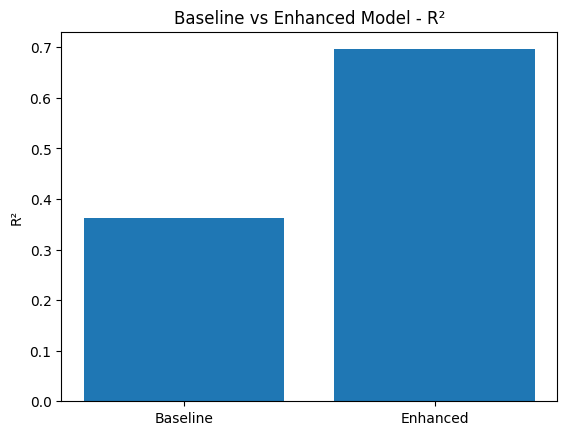

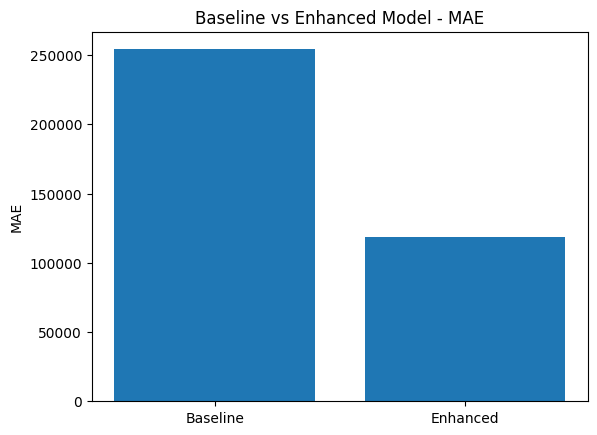

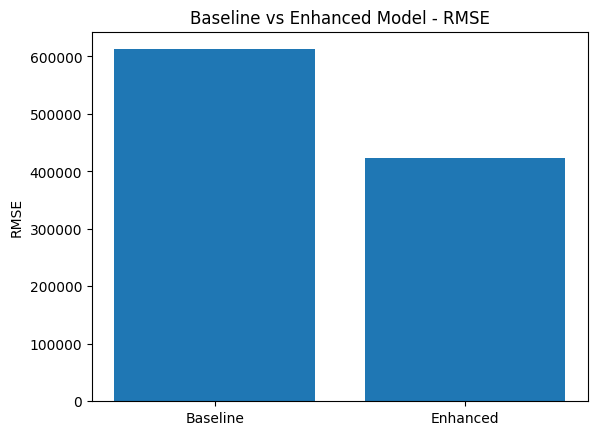

In [30]:
# Bar chart for R²
plt.figure()
plt.bar(["Baseline","Enhanced"], [metrics_base["R2"], metrics_enh["R2"]])
plt.title("Baseline vs Enhanced Model - R²")
plt.ylabel("R²")
plt.savefig("../reports/figures/baseline_vs_enhanced_r2.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Bar chart for MAE
plt.figure()
plt.bar(["Baseline","Enhanced"], [metrics_base["MAE"], metrics_enh["MAE"]])
plt.title("Baseline vs Enhanced Model - MAE")
plt.ylabel("MAE")
plt.savefig("../reports/figures/baseline_vs_enhanced_mae.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Bar chart for RMSE
plt.figure()
plt.bar(["Baseline","Enhanced"], [metrics_base["RMSE"], metrics_enh["RMSE"]])
plt.title("Baseline vs Enhanced Model - RMSE")
plt.ylabel("RMSE")
plt.savefig("../reports/figures/baseline_vs_enhanced_rmse.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


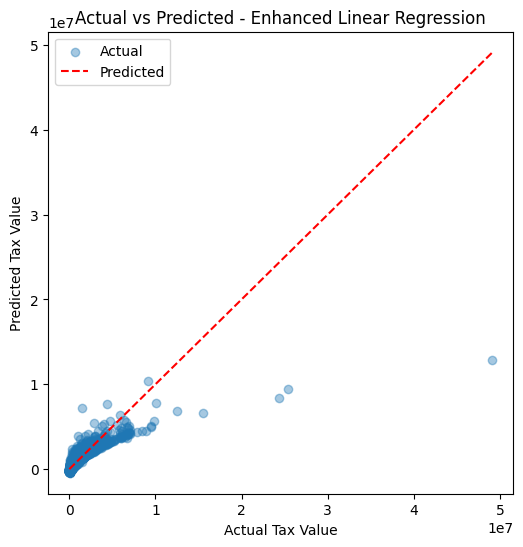

In [35]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_enh, alpha=0.4, label="Actual")
m = [y_test.min(), y_test.max()]
plt.plot(m, m, '--', color="red", label="Predicted")
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Actual vs Predicted - Enhanced Linear Regression")
plt.legend()
plt.savefig("../reports/figures/actual_vs_pred_enhanced.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


Business Insights:

- **Accuracy doubled:** Enhanced model explains ~70% of price variation vs ~36% for the simple baseline.  
- **Reduced errors:** Average pricing errors cut in half (MAE ~$118K vs ~$254K).  
- **Location & features matter:** Encoding location and adding domain-driven ratios significantly improved valuations.  
- **Practical impact:** Realtors can price homes more competitively, investors can better identify undervalued areas, 
  and buyers gain more transparent valuations.  
- **Limitations:** Luxury properties are still underpredicted, suggesting separate modeling strategies for high-end markets. We can test **log-transformed targets** to reduce skew and improve robustness against outliers.


##### Residuals

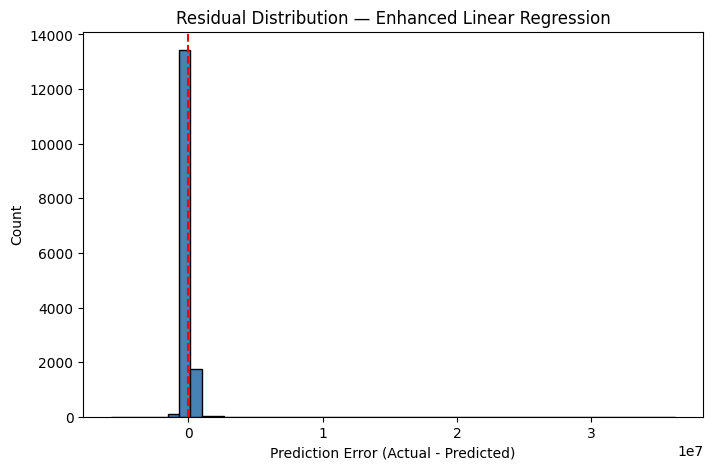

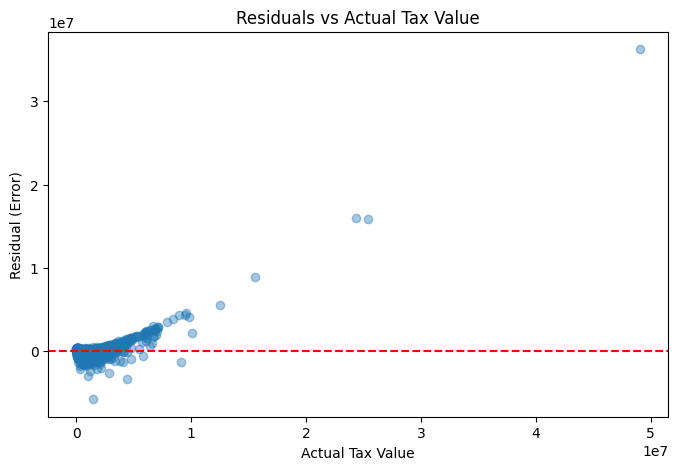

In [28]:
# Residuals
residuals = y_test - pred_enh

# Histogram
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=50, color="steelblue", edgecolor="black")
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution — Enhanced Linear Regression")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Count")
plt.savefig("../reports/figures/residual_histogram.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Residuals vs Actual
plt.figure(figsize=(8,5))
plt.scatter(y_test, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Actual Tax Value")
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual (Error)")
plt.savefig("../reports/figures/residuals_vs_actual.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


**Residual Analysis — Enhanced Linear Regression**

- **Residual Histogram:** Most errors are close to zero, but a long right tail shows the model occasionally underpredicts by millions of dollars. This explains why RMSE is much higher than MAE.
- **Residuals vs Actual Tax Value:** The model performs well for typical homes but systematically underpredicts high-value properties. Residuals grow with actual tax value, indicating model bias in the luxury segment.

**Business Insight:**  
The model is reliable for mass-market properties but not for luxury homes. 
Investors and realtors should use the model cautiously when pricing premium properties 
and may need luxury-specific features or a separate model for that segment.


### **5. Save Cleaned Data**

In [39]:
metrics_df = pd.DataFrame([metrics_base, metrics_enh], index=["Baseline","Enhanced"])
metrics_df.to_csv("../reports/metrics/linear_metrics_baseline_vs_enhanced.csv", index=True)


In [42]:
cleaned_path = "../data/processed/zillow_cleaned_feature_engineered_encoded.csv"
df1.to_csv(cleaned_path, index=False)

### **6. Key Insights**


   - Repaired `roomcnt` by creating **`roomcnt_fixed`** (fallback = bedrooms + bathrooms + 1).
   - Resolved garage inconsistency: if `garagecarcnt > 0` but `garagetotalsqft = 0`, treated as missing and imputed by median **within the same car-count**.
   - Added binary flags: **`has_garage`**
   
**Domain-driven features**
   - `price_per_sqft = taxvaluedollarcnt / sqft`
   - `age_of_home = 2025 - yearbuilt`
   - `rooms_per_sqft = roomcnt_fixed / sqft`
   - `bath_per_bed = bathrooms / (bedrooms + ε)`
   - `garage_sqft_ratio = garagetotalsqft / sqft`

**Encoding categorical variables**
   - Low-cardinality (AC type, heating type, FIPS, county) → **one-hot**.
   - High-cardinality (ZIP, city, neighborhood) → **Top-K one-hot** (Top-50 each; rest “other”).
   - Land-use codes → **Top-K** (Top-15 county land use; Top-5 land use type; rest “other”).
   - Dropped `propertyzoningdesc` due to extreme cardinality/noise.

**Feature sets & split**
   - **Baseline features (4):** sqft, bedrooms, bathrooms, yearbuilt.
   - **Enhanced features (~184):** baseline + engineered + encoded dummies.
   - Single, shared **train/test split** for fair comparison (80/20).

**Baseline vs Enhanced — Linear Regression (raw target)**
   - **Baseline:** R² ≈ 0.36, MAE ≈ \$254K, RMSE ≈ \$613K.
   - **Enhanced:** R² ≈ 0.70, MAE ≈ \$118K, RMSE ≈ \$423K.

##### Interpretation & Business Insights
- **Accuracy meaningfully improved:** Engineered features + location encodings nearly doubled explained variance and **cut average error ~50%**. This enables **more competitive pricing** and better screening of deals.
- **Location & structure matter:** ZIP/city/neighborhood and ratios (e.g., price/ft², garage ratio) add substantial signal beyond raw sqft/beds/baths.
- **Risk still at the high end:** Residual plots show **large underpredictions for luxury homes** (few multi-million-dollar outliers inflate RMSE). Use expert review or a specialized model for that segment.

